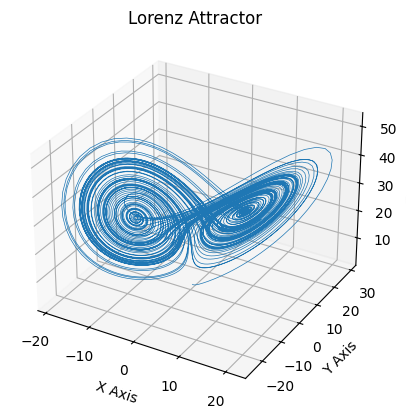

In [1]:
import numpy as np
import matplotlib.pyplot as plt

def lorenz(xyz, *, s=10, r=28, b=2.667):
    """
    Parameters
    ----------
    xyz : array-like, shape (3,)
       Point of interest in three-dimensional space.
    s, r, b : float
       Parameters defining the Lorenz attractor.

    Returns
    -------
    xyz_dot : array, shape (3,)
       Values of the Lorenz attractor's partial derivatives at *xyz*.
    """
    x, y, z = xyz
    x_dot = s*(y - x)
    y_dot = r*x - y - x*z
    z_dot = x*y - b*z
    return np.array([x_dot, y_dot, z_dot])


dt = 0.01
num_steps = 10000

data = np.empty((num_steps + 1, 3))  # Need one more for the initial values
data[0] = (0., 1., 1.05)  # Set initial values


# Step through "time", calculating the partial derivatives at the current point
# and using them to estimate the next point
D = np.array([0.0,0.0,0.0])
for i in range(num_steps):
    data[i + 1] = data[i] + lorenz(data[i].copy()) * dt
    D += (data[i] + lorenz(data[i]))/num_steps

# Plot
ax = plt.figure().add_subplot(projection='3d')

ax.plot(*data.T, lw=0.5)
ax.set_xlabel("X Axis")
ax.set_ylabel("Y Axis")
ax.set_zlabel("Z Axis")
ax.set_title("Lorenz Attractor")

plt.show()

In [7]:
import pulp

# Number of dimensions
num_dim = 3

# Used to create 1D weights
def create_1d_weights(row):
    
    weights = []
    
    for var in range(data.shape[1]):
        
        for col_indx in range(row.shape[1]):

            weights.append(f'w{var}_{col_indx}')
        
    return weights

# Used to create pairwise weights
def create_2d_weights(data):
    
    weights = []
    
    for var in range(data.shape[1]):
        
        for col_indx_1 in range(data.shape[1]):

            for col_indx_2 in range(data.shape[1]):

                if col_indx_1 >= col_indx_2:
                    weights.append(f'w{var}_{col_indx_1}{col_indx_2}')
                
    return weights

def apply_weights_diff(row_1):
    result = []
    for var in range(row_1.shape[0]):
        var_update = 0
        for indx in range(row_1.shape[0]):
            var_update += row_1[indx]*var_1d[f'w{var}_{indx}'].value()
                                               
        for indx_1 in range(row_1.shape[0]):
            for indx_2 in range(row_1.shape[0]):
                if indx_1 >= indx_2:
                    var_update += row_1[indx_2]*row_1[indx_1]*var_2d[f'w{var}_{indx_1}{indx_2}'].value()
    
        result.append( row_1[var] + var_update)
    return result

In [3]:
weights_1d = create_1d_weights(data)

weights_2d = create_2d_weights(data)

var_1d = pulp.LpVariable.dicts('var_1d', weights_1d, lowBound=-100, cat="Continuous")

var_1d_bool = pulp.LpVariable.dicts('var_1d', weights_1d, cat="Boolean")

var_2d = pulp.LpVariable.dicts('var_2d', weights_2d, lowBound=-100, cat="Continuous")

loss_var = [f'x{x}_y{y}' for x in range(data.shape[0]) for y in range(data.shape[1])]

x_vars_abs = pulp.LpVariable.dicts("x_abs",loss_var, lowBound=0, cat="Continuous")

model = pulp.LpProblem("chaos_model", pulp.LpMinimize)


model+=pulp.lpSum(x_vars_abs)

model += pulp.lpSum(x_vars_abs) >= 0

loss = []
for row_indx in range(data.shape[0]-1):
    row_1 = data[row_indx]
    row_2 = data[row_indx+1]

    for var in range(row_1.shape[0]):
        var_update = []
        for indx in range(row_1.shape[0]):
            var_update.append(row_1[indx]*var_1d[f'w{var}_{indx}'])
            


        for indx_1 in range(row_1.shape[0]):
            for indx_2 in range(row_1.shape[0]):
                if indx_1 >= indx_2:
                    var_update.append(row_1[indx_2]*row_1[indx_1]*var_2d[f'w{var}_{indx_1}{indx_2}'])

        lp_sum_var_update = row_1[var] + pulp.lpSum(var_update)

        org_var = row_2[var]
        loss = (org_var - lp_sum_var_update)

        model += x_vars_abs[f'x{row_indx}_y{var}'] >= loss
        model += x_vars_abs[f'x{row_indx}_y{var}'] >= -1*loss


solver = pulp.PULP_CBC_CMD(maxSeconds=660)
solution = model.solve(solver)

print("The Objective Value", pulp.value(model.objective))

C:\Users\rohan\anaconda3\envs\datar\lib\site-packages\pulp\apis\coin_api.py:95: UserWarning: Parameter maxSeconds is being depreciated for timeLimit
  warnings.warn("Parameter maxSeconds is being depreciated for timeLimit")


The Objective Value 0.0


In [4]:
var_1d_saved = {key:var_1d[key].value() for key in var_1d.keys()}
var_1d_saved

{'w0_0': -0.1,
 'w0_1': 0.1,
 'w0_2': 0.0,
 'w1_0': 0.28,
 'w1_1': -0.01,
 'w1_2': 0.0,
 'w2_0': 0.0,
 'w2_1': 0.0,
 'w2_2': -0.02667}

In [5]:
var_2d_saved = {key:var_2d[key].value() for key in var_2d.keys()}
{key:var_2d[key].value() for key in var_2d.keys()}

{'w0_00': 0.0,
 'w0_10': 0.0,
 'w0_11': 0.0,
 'w0_20': -4.2415105e-15,
 'w0_21': 0.0,
 'w0_22': 5.1366339e-16,
 'w1_00': 0.0,
 'w1_10': 0.0,
 'w1_11': 0.0,
 'w1_20': -0.01,
 'w1_21': 0.0,
 'w1_22': 0.0,
 'w2_00': 0.0,
 'w2_10': 0.01,
 'w2_11': 0.0,
 'w2_20': 0.0,
 'w2_21': 0.0,
 'w2_22': 1.5585996e-15}

In [6]:
weights_1d = create_1d_weights(data)

weights_2d = create_2d_weights(data)

var_1d = pulp.LpVariable.dicts('var_1d', weights_1d, lowBound=-100, cat="Continuous")

var_1d_bool = pulp.LpVariable.dicts('var_1d', weights_1d, cat="Boolean")

var_2d = pulp.LpVariable.dicts('var_2d', weights_2d, lowBound=-100, cat="Continuous")

loss_var = [f'x{x}_y{y}' for x in range(data.shape[0]) for y in range(data.shape[1])]

x_vars_abs = pulp.LpVariable.dicts("x_abs",loss_var, lowBound=0, cat="Continuous")

model = pulp.LpProblem("chaos_model", pulp.LpMinimize)


model+=pulp.lpSum(x_vars_abs)

model += pulp.lpSum(x_vars_abs) >= 0

model += var_1d['w0_0'] >= var_1d_saved['w0_0'] + 1e-6

loss = []
for row_indx in range(data.shape[0]-1):
    row_1 = data[row_indx]
    row_2 = data[row_indx+1]

    for var in range(row_1.shape[0]):
        var_update = []
        for indx in range(row_1.shape[0]):
            var_update.append(row_1[indx]*var_1d[f'w{var}_{indx}'])
            


        for indx_1 in range(row_1.shape[0]):
            for indx_2 in range(row_1.shape[0]):
                if indx_1 >= indx_2:
                    var_update.append(row_1[indx_2]*row_1[indx_1]*var_2d[f'w{var}_{indx_1}{indx_2}'])

        lp_sum_var_update = row_1[var] + pulp.lpSum(var_update)

        org_var = row_2[var]
        loss = (org_var - lp_sum_var_update)

        model += x_vars_abs[f'x{row_indx}_y{var}'] >= loss
        model += x_vars_abs[f'x{row_indx}_y{var}'] >= -1*loss


solver = pulp.PULP_CBC_CMD(maxSeconds=660)
solution = model.solve(solver)

print("The Objective Value", pulp.value(model.objective))

The Objective Value 0.001009793684859199


In [ ]:
row_indx = 0
row = data[row_indx]
result = [data[row_indx]]
for _ in range(data.shape[0]-1):
    row = apply_weights_diff(row)
    row = np.array(row)
    result.append(row)

# row_2 = data[row_indx+1]
result = np.array(result)